In [152]:
from importlib import reload
from pyfvtool import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root
from tqdm import tqdm

import sys
sys.path.append('..')
from pymadreq import *
import pymadreq.coreflood as cf
import pymadreq.IO as IO

reload(cf)
reload(IO)

<module 'pymadreq.IO' from 'c:\\Users\\aaeft\\Documents\\GitHub\\PyMADREQ\\examples\\..\\pymadreq\\IO.py'>

## Reading input file and defining the domain

In [153]:
# read the input file
data = IO.read_json("../examples/sample.json")
rel_perm_ww, rel_perm_ow, pc_ww, pc_ow = IO.read_transport_functions(data)
core_plug = IO.read_core_properties(data)
fluids = IO.read_fluids(data)
IC = IO.read_initial_conditions(data) # initial conditions
BC = IO.createFloodingCondition(data["BC"]) # boundary conditions
numerical_params = IO.read_numerical_settings(data)
m = IO.read_flooding_domain(data)

## Transport properties

In [154]:
# define the physical parametrs
SF0 = 0.5 # closer to 1 is water-wet
SF_cell = createCellVariable(m, SF0)
SF=createFaceVariable(m, SF0) # 1 is water wet, 0 is oil wet
# define functions for face variables saturation and wettability indicator
krw = lambda sw, sf:(rel_perm_ww.krw(sw)*sf+rel_perm_ow.krw(sw)*(1-sf))
kro = lambda sw, sf:(rel_perm_ww.kro(sw)*sf+rel_perm_ow.kro(sw)*(1-sf))
pc_imb = lambda sw, sf:(pc_ww.pc_imb(sw)*sf+pc_ow.pc_imb(sw)*(1-sf))
dpc_imb = lambda sw, sf:(pc_ww.dpc_dsw_imb(sw)*sf+pc_ow.dpc_dsw_imb(sw)*(1-sf))
dkrodsw = lambda sw, sf:(rel_perm_ww.dkrodsw(sw)*sf+rel_perm_ow.dkrodsw(sw)*(1-sf))
dkrwdsw = lambda sw, sf:(rel_perm_ww.dkrwdsw(sw)*sf+rel_perm_ow.dkrwdsw(sw)*(1-sf))
sol = root(lambda sw:pc_imb(sw, SF0), SF0*pc_ww.sw_pc0+(1-SF0)*pc_ow.sw_pc0) # saturation at which pc=0
sw_pc0 = sol.x # saturation at which pc=0

## Core and experimental conditions

In [155]:
# core
k= createCellVariable(m, core_plug.permeability)
phi= createCellVariable(m, core_plug.porosity)
lw = geometricMean(k/fluids.water_viscosity)
lo = geometricMean(k/fluids.oil_viscosity)
# A_core = 1
# Initial and boundary conditions
p0 = IC.p # [Pa] pressure
p_back = BC.production_pressure # [Pa] pressure
u_inj = BC.injection_rate_ml_min/(core_plug.cross_sectional_area*1e4) # [cm/min]
u_inj = u_inj/(60*100) # [m/s]
sw0 = IC.sw # initial saturation

## Boundary confitions

In [156]:
BCp = createBC(m) # Neumann BC for pressure
BCs = createBC(m) # Neumann BC for saturation
BCp.right.a[:]=0.0 
BCp.right.b[:]=1.0 
BCp.right.c[:]=p_back
BCp.left.a[:]=1.0 
BCp.left.b[:]=0.0 
BCp.left.c[:]=-u_inj/lw.xvalue[0]
# BCs.right.a[:]=0 
# BCs.right.b[:]=1 
# BCs.right.c[:]=sw_pc0
BCs.left.a[:]=0 
BCs.left.b[:]=1 
BCs.left.c[:]=1.0

## Initial conditions

In [157]:
# initial conditions
sw_old = createCellVariable(m, sw0, BCs)
p_old = createCellVariable(m, p0, BCp)
p = p_old
sw = sw_old
uw = -gradientTerm(p_old)  # an estimation of the water velocity
oil_init = domainInt(1 - sw_old)
rec_fact = np.array([0])
t_day = np.array([0])
t = 0.0

## Numerical settings

In [158]:
# define the time step and solver properties
dt=1
dt0=dt
t_end = numerical_params.simulation_time # [s] final simulation time
eps_p = numerical_params.eps_p # pressure accuracy
eps_sw = numerical_params.eps_sw # saturation accuracy
dsw_alwd= numerical_params.dsw_allowed
dp_alwd= numerical_params.dp_allowed # Pa
dt = numerical_params.time_step # [s] initial time step

## Core flooding with end effect
Here, we will simulate a core flooding experiment with end effect. The injection rate is bumped 5 times.

In [159]:
t_end1 = t_end*0.8
t_end2 = 1.2*t_end
pbar = tqdm(total=t_end2)
while (t<t_end2):
# for i=1:5
    error_p = 1e5
    error_sw = 1e5
    # Implicit loop
#     while ((error_p>eps_p) || (error_sw>eps_sw))
    while(1): # loop condition is checked inside
        pgrad = gradientTerm(p)
        sw_face = upwindMean(sw, -pgrad) # average value of water saturation
        sw_grad=gradientTerm(sw)
        sw_ave=arithmeticMean(sw)
        BC2GhostCells(sw)
        pc_cell = funceval(pc_imb, sw, SF_cell)
        pcgrad = gradientTermFixedBC(pc_cell)
        labdao = lo*faceeval(kro, sw_face, SF)
        labdaw = lw*faceeval(krw, sw_face, SF)
        labda = labdao+labdaw
        Mdiffp1 = diffusionTerm(-labda)
        RHSpc1=divergenceTerm(labdao*pcgrad)
        if t>t_end1:
            BCp.left.a[:]=1.0 
            BCp.left.b[:]=0.0 
            BCp.left.c[:]=-5*u_inj/lw.xvalue[0]
        [Mbcp, RHSbcp] = boundaryConditionTerm(BCp)
        RHS1 = RHSpc1+RHSbcp # with capillary
        p_new=solvePDE(m, Mdiffp1+Mbcp, RHS1)
        # solve for Sw
        pgrad = gradientTerm(p_new)
        uw=-labdaw*pgrad
        [Mbcsw, RHSbcsw] = boundaryConditionTerm(BCs)
        RHS_sw=-divergenceTerm(uw)
        sw_new=solveExplicitPDE(sw_old, dt, RHS_sw/phi.value.ravel(), BCs)
        error_p = np.max(np.abs((p_new.value[:]-p.value[:])/p_new.value[:]))
        error_sw = np.max(np.abs(sw_new.internalCells()-sw.internalCells()))
        # calculate new time step
        dt_new=min(10*dt, dt*dsw_alwd/error_sw)
        # assign new values of p and sw
        if error_sw>dsw_alwd:
            dt=dt*(dsw_alwd/error_sw)
        else:
            t=t+dt
            p.update_value(p_new)
            sw.update_value(sw_new)
            p_old.update_value(p)
            sw_old.update_value(sw)
            dt = min(dt*(dsw_alwd/error_sw), 10*dt)
            break
    
    # Calculate the new concentration profile after advection-diffusion
    
    # calculate the new concentrations after chemical reactions
    
    # update rel-perm and pc curves

    # new boundary
    if sw_ave.xvalue[-1]>=sw_pc0:
        BCs.right.a[:] = 0. 
        BCs.right.b[:] = 1. 
        BCs.right.c[:]=sw_pc0
    # calculate recovery factor
    pbar.update(t-pbar.n)
    rec_fact= np.append(rec_fact, (oil_init-domainInt(1-sw))/oil_init)
    t_day = np.append(t_day, t)


120123.04143219255it [00:13, 8629.11it/s]                               
 98%|█████████▊| 118031.99853236374/120000.0 [00:03<00:00, 28647.21it/s]

In [160]:
t_end1

80000.0

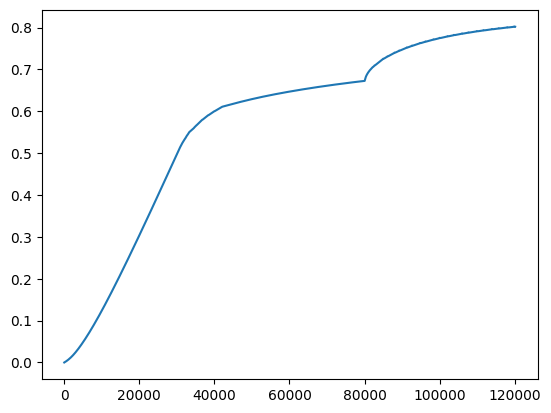

In [161]:
plt.plot(t_day, rec_fact, label='Recovery factor')

## Two phase flow without Pc

In [ ]:
t_end1 = t_end*0.8
t_end2 = 1.2*t_end
pbar = tqdm(total=t_end2)
while (t<t_end2):
# for i=1:5
    error_p = 1e5
    error_sw = 1e5
    # Implicit loop
#     while ((error_p>eps_p) || (error_sw>eps_sw))
    while(1): # loop condition is checked inside
        pgrad = gradientTerm(p)
        sw_face = upwindMean(sw, -pgrad) # average value of water saturation
        sw_grad=gradientTerm(sw)
        sw_ave=arithmeticMean(sw)
        BC2GhostCells(sw)
        pc_cell = funceval(pc_imb, sw, SF_cell)
        pcgrad = gradientTermFixedBC(pc_cell)
        labdao = lo*faceeval(kro, sw_face, SF)
        labdaw = lw*faceeval(krw, sw_face, SF)
        labda = labdao+labdaw
        Mdiffp1 = diffusionTerm(-labda)
        RHSpc1=divergenceTerm(labdao*pcgrad)
        if t>t_end1:
            BCp.left.a[:]=1.0 
            BCp.left.b[:]=0.0 
            BCp.left.c[:]=-5*u_inj/lw.xvalue[0]
        [Mbcp, RHSbcp] = boundaryConditionTerm(BCp)
        RHS1 = RHSpc1+RHSbcp # with capillary
        p_new=solvePDE(m, Mdiffp1+Mbcp, RHS1)
        # solve for Sw
        pgrad = gradientTerm(p_new)
        uw=-labdaw*pgrad
        [Mbcsw, RHSbcsw] = boundaryConditionTerm(BCs)
        RHS_sw=-divergenceTerm(uw)
        sw_new=solveExplicitPDE(sw_old, dt, RHS_sw/phi.value.ravel(), BCs)
        error_p = np.max(np.abs((p_new.value[:]-p.value[:])/p_new.value[:]))
        error_sw = np.max(np.abs(sw_new.internalCells()-sw.internalCells()))
        # calculate new time step
        dt_new=min(10*dt, dt*dsw_alwd/error_sw)
        # assign new values of p and sw
        if error_sw>dsw_alwd:
            dt=dt*(dsw_alwd/error_sw)
        else:
            t=t+dt
            p.update_value(p_new)
            sw.update_value(sw_new)
            p_old.update_value(p)
            sw_old.update_value(sw)
            dt = min(dt*(dsw_alwd/error_sw), 10*dt)
            break
    
    # Calculate the new concentration profile after advection-diffusion
    
    # calculate the new concentrations after chemical reactions
    
    # update rel-perm and pc curves

    # new boundary
    if sw_ave.xvalue[-1]>=sw_pc0:
        BCs.right.a[:] = 0. 
        BCs.right.b[:] = 1. 
        BCs.right.c[:]=sw_pc0
    # calculate recovery factor
    pbar.update(t-pbar.n)
    rec_fact= np.append(rec_fact, (oil_init-domainInt(1-sw))/oil_init)
    t_day = np.append(t_day, t)